# Creacion del modelo 

In [1]:
# Importo las librerias correspondientes para la creacion del modelo

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



### 1. Obtencion y organizacion de los datos

In [2]:
# Cargo el dataset modificado en el EDA

dataframe_unido_modelo = pd.read_parquet('Datasets/dataset_unido_modelo')
print(f"Dimensiones del DataFrame: {dataframe_unido_modelo.shape}")


Dimensiones del DataFrame: (24004, 12)


### 2. Vectorizacion de las características numericas

In [3]:
# Vectorizo las características numéricas

caracteristicas_numericas = ['budget', 'revenue', 'vote_count', 'popularity']
escala = StandardScaler()
caracteristicas_numericas_normalizadas = escala.fit_transform(dataframe_unido_modelo[caracteristicas_numericas])
matrix_numerica_escalada = csr_matrix(caracteristicas_numericas_normalizadas)


### 3. Vectorización de las características categóricas

In [4]:
# Vectorizo el género y aplico un peso mayor a esta matriz

vectorizar_genero = TfidfVectorizer(stop_words='english')
matrix_tfidf_genero = vectorizar_genero.fit_transform(dataframe_unido_modelo['name_genre'])
peso_del_genero = 6.0
matrix_tfidf_genero_ponderado = peso_del_genero * matrix_tfidf_genero

# Combino las columnas relevantes en una sola columna para la vectorización

dataframe_unido_modelo['texto_combinado'] = (
    dataframe_unido_modelo['cast_name_actor'] + ' ' +
    dataframe_unido_modelo['crew_name_member'] + ' ' +
    dataframe_unido_modelo['overview']
)

# Reemplazo valores nulos en la columna combinada con una cadena vacía
dataframe_unido_modelo['texto_combinado'] = dataframe_unido_modelo['texto_combinado'].fillna('')

# Elimino caracteres no deseados como comas
dataframe_unido_modelo['texto_combinado'] = dataframe_unido_modelo['texto_combinado'].str.replace(',', ' ')

# Vectorizo el texto combinado (actores, directores, overview)

vectorizar_texto_combinado = TfidfVectorizer(stop_words='english')
matrix_tfidf_combinado = vectorizar_texto_combinado.fit_transform(dataframe_unido_modelo['texto_combinado'])


### 4. Combinación de características:


In [5]:
# Combino la matriz numérica, la matriz ponderada de géneros y la matriz de texto combinado
caracteristicas_combinadas = hstack([matrix_numerica_escalada, matrix_tfidf_genero_ponderado, matrix_tfidf_combinado])

### 5. Realizar el calculo de la similitud del coseno

In [6]:
# Aseguro que la matriz combinada es de tipo csr_matrix
if not isinstance(caracteristicas_combinadas, csr_matrix):
    caracteristicas_combinadas = csr_matrix(caracteristicas_combinadas)

# Reduzco la dimensionalidad con SVD
svd = TruncatedSVD(n_components=100)
caracteristicas_reducidas = svd.fit_transform(caracteristicas_combinadas)

# Calculo la matriz de similitud del coseno
similitud_del_coseno = cosine_similarity(caracteristicas_reducidas)

In [7]:
# Preproceso los titulos en minusculas solo una vez fuera de la funcion
dataframe_unido_modelo['title_lower'] = dataframe_unido_modelo['title'].str.lower()

def recomendacion(title: str):
    """
    Recomienda peliculas similares a una pelicula dada basada en la similitud del coseno.

    Parametros:
        title: El título de la película para la cual se desean obtener recomendaciones.
        similitud_del_coseno: La matriz de similitud del coseno entre peliculas.

    Retorna:
        Si el titulo es valido retorna una lista de 5 títulos de películas recomendadas que son más similares a la película dada.
        Si el titulo no es valido retorna un mensaje indicando que el título no se encuentra disponible en la base de datos.
    """
    # Normalizo el título para comparar sin importar mayúsculas/minúsculas
    title = title.lower()

    # Verifico si el título está en el DataFrame
    if title not in dataframe_unido_modelo['title_lower'].values:
        return {"error": f"La película '{title}' no se encuentra dentro de la muestra de datos."}
    
    # Obtengo el índice de la película dada
    idx = dataframe_unido_modelo[dataframe_unido_modelo['title_lower'] == title].index[0]
    
    # Si la matriz de similitud es dispersa, trabajo directamente con ella sin convertir a densa
    if isinstance(similitud_del_coseno, csr_matrix):
        sim_scores = similitud_del_coseno[idx].toarray().flatten()
    else:
        sim_scores = similitud_del_coseno[idx]
    
    # Obtener los índices de las 5 películas más similares
    sim_scores_idx = np.argsort(sim_scores)[::-1]
    sim_scores_idx = sim_scores_idx[sim_scores_idx != idx]  # Excluir la película misma
    
    top_5_indices = sim_scores_idx[:5]  # Obtener los 5 primeros índices
    
    # Obtener los títulos de las películas recomendadas
    top_5_titles = dataframe_unido_modelo.iloc[top_5_indices]['title'].tolist()
    
    return {"recomendaciones": top_5_titles}

In [8]:
# Realizo una verificacion con distintos titulos de peliculas para observar el funcionamiento del modelo

print("Recomendaciones para 'The Avengers':")
print(recomendacion('The Avengers'))

print("\nRecomendaciones para 'Men in Black':")
print(recomendacion('Men in Black'))

print("\nRecomendaciones para 'toy story':")
print(recomendacion('toy story'))

print("\nRecomendaciones para 'john wick:")
print(recomendacion('john wick'))

print("\nRecomendaciones para 'titanic':")
print(recomendacion('titanic'))

print("\nRecomendaciones para 'saw':")
print(recomendacion('saw'))

print(recomendacion('bee'))

Recomendaciones para 'The Avengers':
{'recomendaciones': ['Out of Time', 'The Missing', 'Hard Rain', 'U.S. Marshals', 'Original Sin']}

Recomendaciones para 'Men in Black':
{'recomendaciones': ['The Incredibles', 'Terminator 2: Judgment Day', 'Sherlock Holmes', 'The Bourne Ultimatum', 'Captain America: The Winter Soldier']}

Recomendaciones para 'toy story':
{'recomendaciones': ['Despicable Me', 'Ice Age', 'Monsters, Inc.', 'Aladdin', 'Toy Story 2']}

Recomendaciones para 'john wick:
{'recomendaciones': ['Baby Driver', 'Wonder Woman', 'Minions', 'Deadpool', 'Gone Girl']}

Recomendaciones para 'titanic':
{'recomendaciones': ['Star Wars: The Force Awakens', 'Inside Out', 'Jurassic World', 'Harry Potter and the Deathly Hallows: Part 2', 'Frozen']}

Recomendaciones para 'saw':
{'recomendaciones': ['The Purge: Anarchy', '28 Days Later', 'Insidious', 'It Follows', 'Shaun of the Dead']}
{'error': "La película 'bee' no se encuentra dentro de la muestra de datos."}


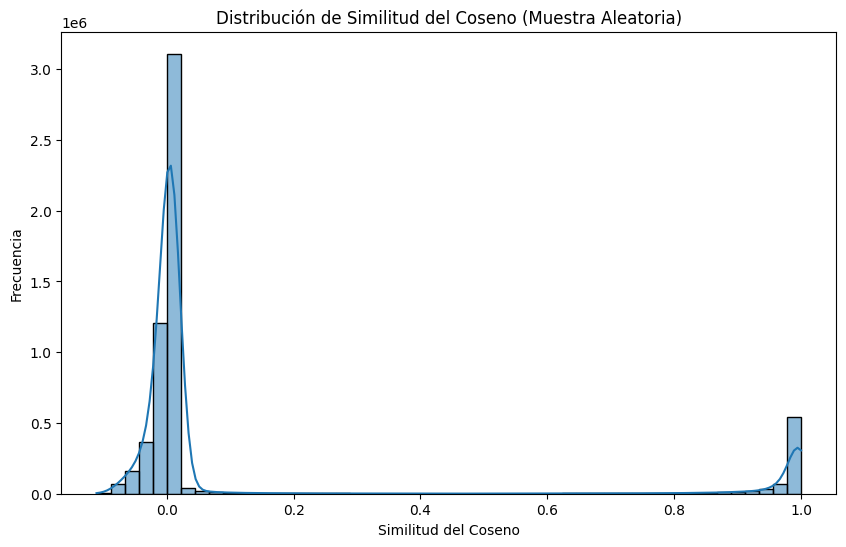

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extraer una muestra aleatoria del 1% de los elementos de la matriz
sample_size = int(similitud_del_coseno.size * 0.01)
sample_indices = np.random.choice(similitud_del_coseno.size, sample_size, replace=False)
similitud_sampled = similitud_del_coseno.flatten()[sample_indices]

plt.figure(figsize=(10, 6))
sns.histplot(similitud_sampled, bins=50, kde=True)
plt.title('Distribución de Similitud del Coseno (Muestra Aleatoria)')
plt.xlabel('Similitud del Coseno')
plt.ylabel('Frecuencia')
plt.show()